In [1]:
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import kurtosis
np.random.seed(1)
import torch

In [2]:
# Data generation
mat1 = sio.loadmat('Bearing/N_0.mat')
data1 = mat1['X097_DE_time']
mat2 = sio.loadmat('Bearing/IR007_0.mat')
data2 = mat2['X105_DE_time']
x1 = np.zeros([50,4])
x2 = np.zeros([50,4])
for i in range(50):
    x1[i, 0] = np.mean(data1[i*2000:(i+1)*2000]) 
    x1[i, 1] = np.std(data1[i*2000:(i+1)*2000]) 
    x1[i, 2] = kurtosis(data1[i*2000:(i+1)*2000])
    x1[i, 3] = 0 #0 refers to normal
    x2[i, 0] = np.mean(data2[i*2000:(i+1)*2000]) 
    x2[i, 1] = np.std(data2[i*2000:(i+1)*2000]) 
    x2[i, 2] = kurtosis(data2[i*2000:(i+1)*2000])
    x2[i, 3] = 1 #1 refers to faulty type


# feature normalization
for i in range(x1.shape[1]-2):
   data_ = x1[:,i]
   x1[:,i] = (data_-np.amin(data_))/(np.amax(data_)-np.amin(data_))
for i in range(x2.shape[1]-2):
   data_ = x2[:,i]
   x2[:,i] = (data_-np.amin(data_))/(np.amax(data_)-np.amin(data_))
    
X = np.concatenate((x1,x2), axis = 0) # X: 100*4
# split the training and test datasets
index = np.arange(X.shape[0]) #index: 0:99
np.random.shuffle(index) #shuffle the index
m = np.ceil(0.7*X.shape[0]) #training:test = 7:3
m = int(m) #split point
X_Train = X[index[0:m],0:3]
X_Test = X[index[m:-1],0:3]
Y_Train = X[index[0:m],-1]
Y_Test = X[index[m:-1],-1]

# convert numpy array to torch tensor
X_Train_Tensor = torch.tensor(X_Train).float()
X_Test_Tensor = torch.tensor(X_Test).float()
Y_Train_Tensor = torch.tensor(Y_Train).long()
Y_Test_Tensor = torch.tensor(Y_Test).long()

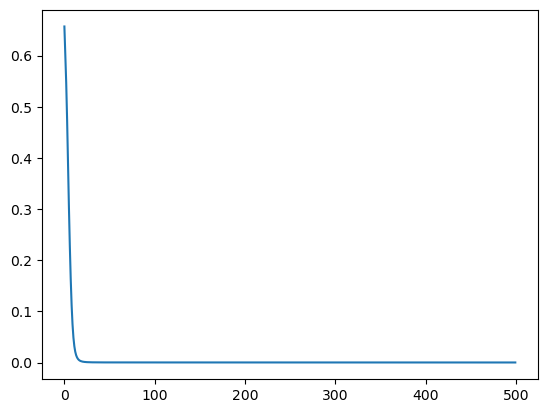

In [3]:
class Net(torch.nn.Module):
    def __init__(self, layer_numbers):
        super().__init__()
        self.hidden = torch.nn.Linear(layer_numbers[0],layer_numbers[1],bias = False)
        self.output = torch.nn.Linear(layer_numbers[1],layer_numbers[2],bias = False)
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self, x):
        x = self.hidden(x) #x: 70*3 -> 70*7
        x = self.sigmoid(x)#x: 70*7 -> 70*7
        x = self.output(x) #x: 70*7 -> 70*2
        return x

layer_numbers = [3,7,2]
epochs = 500
net = Net(layer_numbers)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.1)
loss_history = np.zeros(epochs)

for epoch in range(epochs):
    #forward process
    Y_pred = net(X_Train_Tensor)
    
    #loss
    loss = criterion(Y_pred,Y_Train_Tensor)
    #calculate gradients in backpropagation
    optimizer.zero_grad()
    loss.backward()
    #update weights
    optimizer.step()
    
    loss_history[epoch] = loss

plt.plot(np.arange(epochs),loss_history)  

In [4]:
Y_Prediction_Train = torch.max(net(X_Train_Tensor),1)[1] #70*2 ->70*1(maximum output), np.argmax, [1] index fo the maximum value
print(Y_Prediction_Train)
print(Y_Prediction_Train == Y_Train_Tensor)

tensor([1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
        0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
        0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])


In [5]:
Y_Prediction_Test = torch.max(net(X_Test_Tensor),1)[1] #70*2 ->70*1(maximum output), np.argmax, [1] index fo the maximum value
print(Y_Prediction_Test == Y_Test_Tensor)

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True])
